In [ ]:
import glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.applications import VGG19
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from numpy.random import choice
import shutil
MODELS_PATH = '/content/drive/MyDrive/DeepProject/models'
OLD_MODEL_PATH = os.path.join(MODELS_PATH, 'old')
zip_dir = '/content/drive/MyDrive/DeepProject/immagini1.zip'
models_path = '/content/drive/MyDrive/DeepProject/models'
root_dir = '/content/drive/MyDrive/DeepProject'
loss_checkpoint = os.path.join(root_dir, 'checkpoints')
data_dir = '/content/immagini/DIV2K_'


In [ ]:
#import the drive folder and fetch the images
if not os.path.exists('immagini/'):
  drive.mount('/content/drive/',force_remount=True)
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall('immagini')

In [ ]:
# use gdrive to definetily delete models file and all elements in the tresholds
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

Generator and Generator Parameters

In [ ]:
common_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.7)
high_resolution_shape = (256, 256, 3)
low_resolution_shape = (None, None, 3)

In [ ]:
def residual_block(x):
  filters = 64 #64 channels
  kernel_size = 3
  strides = 1
  padding = "same"
  momentum = 0.8
  res = Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding)(x)
  res = BatchNormalization(momentum=momentum)(res)
  res = PReLU(shared_axes=[1,2])(res)
  res = Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding)(res)
  res = BatchNormalization(momentum=momentum)(res)
  # Add res and x
  res = Add()([res, x])
  return res

def pixel_shuffle(data, scale):
  return UpSampling2D(size=scale)(data)

def upscale_block(data):
  filters=256
  kernel_size=3
  strides=1
  padding='same'

  data = Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding)(data)
  data = pixel_shuffle(data, 2)
  data = PReLU(shared_axes=[1,2])(data)
  return data

In [ ]:
def build_generator(input_shape):
  residual_blocks = 16
  momentum = 0.8

  # Input Layer of the generator network
  input_layer = Input(shape=input_shape)
  #pre-residual block
  gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(input_layer)
  gen1 = PReLU(shared_axes=[1,2])(gen1)
  #add residual blocks
  res = residual_block(gen1)
  for i in range(residual_blocks - 1):
   res = residual_block(res)
  #post-residual
  gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
  gen2 = BatchNormalization(momentum=momentum)(gen2)
  gen3 = Add()([gen2, gen1])
  #upscaler
  gen4 = upscale_block(gen3)
  gen5 = upscale_block(gen4)
  # Output
  output = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
  #model
  model = Model(inputs=[input_layer], outputs=[output],name='generator')
  return model

In [ ]:
generator = build_generator(low_resolution_shape)

Discriminator and Discriminator Parameters

In [ ]:
def disc_basic_block(data, filters, strides):
  leakyrelu_alpha = 0.2
  momentum = 0.8
  kernel_size = 3
  padding = 'same'

  data = Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding)(data)
  data = BatchNormalization(momentum=momentum)(data)
  data = LeakyReLU(alpha=leakyrelu_alpha)(data)
  return data

In [ ]:
def build_discriminator(input_shape):
  leakyrelu_alpha = 0.2
  momentum = 0.8
  num_disc_block = 7
  dis_block_filters = [128, 128, 256, 256, 512, 512]
  dis_block_strides = [1, 2, 1, 2, 1, 2 ]

  input_layer = Input(shape=input_shape)
  # pre-discriminator basic blocks
  dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
  dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

  dis_ = disc_basic_block(dis1, 64, 2)
  for i in range(num_disc_block - 1):
   dis_ = disc_basic_block(dis_, dis_block_filters[i], dis_block_strides[i])

  # post-discriminator basic blocks
  dis2 = Flatten()(dis_)
  dis3 = Dense(units=1024)(dis2)
  dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
  output = Dense(units=1, activation='sigmoid')(dis3)

  model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
  return model

In [ ]:
discriminator = build_discriminator(high_resolution_shape)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

building VGG19

In [ ]:
def build_vgg():
  input_shape = (256, 256, 3)
  vgg = VGG19(weights="imagenet",include_top=False, input_shape=input_shape)
  model = Model(inputs=vgg.inputs, outputs=vgg.layers[9].output)
  return model


In [ ]:
vgg = build_vgg()
vgg.trainable = False

In [ ]:
def build_adversarial_model(generator, discriminator, vgg):

  # input layer for high-resolution images and low-resolution images
  input_high_resolution = Input(shape=high_resolution_shape)
  input_low_resolution = Input(shape=low_resolution_shape)

  # generate high-resolution images from low-resolution images
  generated_high_resolution_images = generator(input_low_resolution)

  # extract feature maps from generated images
  features = vgg(tf.keras.applications.vgg19.preprocess_input(generated_high_resolution_images*255.))

  # make a discriminator non-trainable
  discriminator.trainable = False

  # discriminator will give us a probability estimation for the generated high-resolution images
  probs = discriminator(generated_high_resolution_images)

  # create and compile
  adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
  return adversarial_model

In [ ]:
adversarial_model = build_adversarial_model(generator, discriminator, vgg)
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 6e-3], optimizer=common_optimizer)

Data and Batch handling

In [ ]:
class Loader:
  def __init__(self, batch_size: int = 8, set_type="train"):
    self.selectedType = set_type
    self.batch_size = batch_size
    self.nimages = len(os.listdir('/content/immagini/DIV2K_' + self.selectedType + f"/{'LR' if self.selectedType == 'test' else 'HR'}"))
    self.nbatches = (self.nimages // batch_size) + (1 if (self.nimages % batch_size) > 0 else 0)
    self.batch_counter = 0
    self.all_images = glob.glob(f"{data_dir}{self.selectedType}/{'HR/*.png' if self.selectedType == 'train' else 'LR/*.jpg'}", recursive=True)
    random.shuffle(self.all_images)
    self.index = 0
    self.len = len(self.all_images)
    pass

  def resizing_cropping(self,img):
    img1 = cv2.imread(img)
    h = img1.shape[0]
    w = img1.shape[1]
    random_h = random.randint(0,h-256)
    random_w = random.randint(0,w-256)
    img1 = img1[random_h:random_h+256, random_w:random_w+256]
    img1_high_resolution = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    if np.random.random() < 0.5:
      img1_high_resolution = cv2.flip(img1_high_resolution, choice([0,1], 1)[0])
    if choice([0,1], 1)[0] == 1:
      img1_high_resolution = cv2.rotate(img1_high_resolution, choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE], 1)[0])
    img1_low_resolution = cv2.resize(img1_high_resolution, (64,64), interpolation=cv2.INTER_CUBIC)
    return img1_high_resolution,img1_low_resolution

  def __iter__(self):
    return self

  def __len__(self): # utile per usare loader in tqdm
    return self.nbatches

  def sample_images(self):
    images_batch = []
    for i in range(self.batch_size):
      position = (self.batch_counter * self.batch_size +i) % self.len
      if position >= self.len:
        break
      images_batch.append(self.all_images[position])
    HR = []
    LR = []
    for img in images_batch:
      img1_high_resolution,img1_low_resolution = self.resizing_cropping(img)
      HR.append(img1_high_resolution)
      LR.append(img1_low_resolution)
    HR = np.array(HR) / 255.
    LR = np.array(LR) / 255.
    return HR, LR

  def __next__(self):
    batch_HR = []
    batch_LR = []
    if self.batch_counter == self.nbatches:
      self.reset()
      random.shuffle(self.all_images)
      raise StopIteration

    batch_HR,batch_LR = self.sample_images()
    self.batch_counter+=1
    return batch_HR,batch_LR


  def sample_images_eval(self):
    # Make a list of all images inside the data directory of the LR images
    all_images_HR = glob.glob(f'{data_dir}{self.selectedType}/HR/*.png', recursive=True)
    all_images_LR = []
    all_images_LR = glob.glob(f'{data_dir}{self.selectedType}/LR/*x4.png', recursive=True)
    all_images_HR.sort()
    all_images_LR.sort()
    return all_images_HR,all_images_LR

  def reset(self):
    self.batch_counter = 0

  def save_images(self, original_im, sr_im,original_HR_im,selectedType, epoch : int = 0,):
    path = os.path.join('/content/drive/MyDrive/DeepProject/results/', selectedType)
    if not os.path.exists(path):
      os.makedirs(path)

    #if epoch == 0 or epoch % 3 == 0 or selectedType == 'valid':
    plt.imshow(original_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'or')))
    plt.show()

    plt.imshow(sr_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'sr')))
    plt.show()

    plt.imshow(original_HR_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'or_HR')))
    plt.show()


utilities function

In [ ]:
def save_weights(gen_model,disc_model,adversarial_model,epoch):
  files_list = glob.glob(f'{MODELS_PATH}/*.hdf5')
  for files in files_list:
      shutil.move(files, OLD_MODEL_PATH )

  modelname = os.path.join(MODELS_PATH, f'genblock_{epoch}.hdf5')
  gen_model.save(modelname)

  modelname = os.path.join(MODELS_PATH, f'disblock_{epoch}.hdf5')
  disc_model.save(modelname,include_optimizer=True)

  modelname = os.path.join(MODELS_PATH, f'ganblock_{epoch}.hdf5')
  adversarial_model.save(modelname,include_optimizer=True)

  filelist = glob.glob(f'{OLD_MODEL_PATH}/*')
  for f in filelist:
    os.remove(f)
  clean_trash()

def save_checkpoint(d_losses,g_losses_avg, g_losses_binary, g_losses_mse,psnr,ssim,selectedType):
  line = f'{d_losses};{g_losses_avg};{g_losses_binary};{g_losses_mse};{psnr};{ssim}\n'
  # save losses
  with open(os.path.join(loss_checkpoint,f'losses_{selectedType}.chk'), mode="a") as loss_file:
    loss_file.write(line)

def save_checkpoint_eval(psnr,ssim):
  for i,el in enumerate(range(len(psnr))):
    line = f'{psnr[i]};{ssim[i]}\n'
    # save losses
    with open(os.path.join(loss_checkpoint,f'losses_eval.chk'), mode="a") as loss_file:
      loss_file.write(line)

def load_checkpoint(selectedType):
    d_losses = []
    g_losses_avg = []
    g_losses_binary = []
    g_losses_mse = []
    psnr = []
    ssim = []
    with open(os.path.join(loss_checkpoint,f"losses_{'eval' if selectedType == 'valid' else selectedType}.chk"), "r") as loss_files:
      if selectedType == 'valid':
        while line := loss_files.readline():
          ps,ss = line.split(";")
          psnr.append(float(ps))
          ssim.append(float(ss))
        return np.array(psnr), np.array(ssim)
      else:
        while line := loss_files.readline():
          d_loss,g_loss_avg,g_loss_bin,g_loss_mse,ps,ss = line.split(";")
          d_losses.append(float(d_loss))
          g_losses_avg.append(float(g_loss_avg))
          g_losses_binary.append(float(g_loss_bin))
          g_losses_mse.append(float(g_loss_mse))
          psnr.append(float(ps))
          ssim.append(float(ss))
    return np.array(d_losses), np.array(g_losses_avg), np.array(g_losses_binary), np.array(g_losses_mse), np.array(psnr), np.array(ssim), len(g_losses_avg)

def load_weights():
  all_weights = glob.glob(f'{MODELS_PATH}/*.hdf5', recursive=True)
  #load wheigh set epoch
  initial_epoch = 0
  if all_weights:
    for m in all_weights:
      initial_epoch = int(m.split('_')[-1].split('.')[0])+1
      if 'disblock' in m:
        discriminator.load_weights(m)
        print(f'loaded discriminator, ',m)
      elif 'genblock' in m:
        generator.load_weights(m)
        print('loaded gen, ',m)
      else:
        adversarial_model.load_weights(m)
        print('loaded gan, ',m)
  return initial_epoch

def clean_trash():
  # clear trash
  for a_file in my_drive.ListFile({'q': "trashed = true"}).GetList():
    print(f'the file "{a_file["title"]}", is about to get deleted permanently.')
    try:
      a_file.Delete()
    except Exception as e:
      print(e)



Configure and Train

In [ ]:
def train_computeLoss(batch_size, nbatches, epoch, initial_epoch,image_loader):
  g_losses_avg = []
  g_losses_binary = []
  g_losses_mse = []
  d_losses = []
  psnr = []
  ssim = []

  gen_label = np.zeros((batch_size, 1))

  for hr_imgs,lr_imgs in tqdm(image_loader, desc=f"[*] Epoch=> {epoch}"):
    real_label = np.ones((batch_size, 1))
    real_label = real_label - 0.05 * np.random.uniform(size = (batch_size,1))

    if hr_imgs is None:
      return False # failure

    gen_imgs = generator.predict_on_batch(lr_imgs)

    #discriminator.trainable = True
    discriminator.trainable = False

    #Train the discriminator
    d_loss_real = discriminator.train_on_batch(hr_imgs,real_label)
    d_loss_gen = discriminator.train_on_batch(gen_imgs,gen_label)
    discriminator.trainable = False
    d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

    image_features = vgg.predict(tf.keras.applications.vgg19.preprocess_input(hr_imgs*255.))

    #Train the generator
    g_loss_avg, g_loss_binary, g_loss_mse  = adversarial_model.train_on_batch([lr_imgs, hr_imgs],[real_label,image_features])

    batches_psnr = tf.image.psnr(tf.clip_by_value(tf.cast(hr_imgs, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_imgs, tf.float32), 0, 1), max_val=1)
    batches_ssim = tf.image.ssim(tf.clip_by_value(tf.cast(hr_imgs, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_imgs, tf.float32), 0, 1), max_val=1)
    psnr.append(tf.reduce_mean(batches_psnr))
    ssim.append(tf.reduce_mean(batches_ssim))

    d_losses.append(d_loss)
    g_losses_avg.append(g_loss_avg)
    g_losses_binary.append(g_loss_binary)
    g_losses_mse.append(g_loss_mse)

  g_losses_avg = np.array(g_losses_avg)
  g_losses_binary = np.array(g_losses_binary)
  g_losses_mse = np.array(g_losses_mse)
  d_losses = np.array(d_losses)
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  g_loss_avg = np.sum(g_losses_avg) / len(g_losses_avg)
  g_loss_binary = np.sum(g_losses_binary) / len(g_losses_binary)
  g_loss_mse = np.sum(g_losses_mse) / len(g_losses_mse)
  d_loss = np.sum(d_losses) / len(d_losses)
  ssim =  np.sum(ssim) / len(ssim)
  psnr =  np.sum(psnr) / len(psnr)

  print(f'epoch= {epoch} g_loss_avg = {g_loss_avg} --> d_loss = {d_loss} --> ssim = {ssim} -->psnr = {psnr}\n')

  return lr_imgs[0],gen_imgs[0], hr_imgs[0], d_loss, g_loss_avg, g_loss_binary, g_loss_mse, ssim, psnr



In [ ]:
def test_computeLoss(batch_size, nbatches, initial_epoch,image_loader):
  bce = tf.keras.losses.BinaryCrossentropy()
  mse = tf.keras.losses.MeanSquaredError()

  g_losses_avg = []
  g_losses_binary = []
  g_losses_mse = []
  d_losses = []
  psnr = []
  ssim = []

  gen_label = np.zeros((batch_size, 1))
  real_label = np.ones((batch_size, 1))

  discriminator.trainable = False
  generator.trainable = False

  for hr_imgs,lr_imgs in tqdm(image_loader, desc=f"[*] Epoch=> {initial_epoch}"):

    if hr_imgs is None:
      return False

    gen_imgs = generator.predict_on_batch(lr_imgs)

    probs_gen = discriminator.predict_on_batch(gen_imgs)
    probs_hr = discriminator.predict_on_batch(hr_imgs)

    bce_disc_gen = bce(gen_label,probs_gen)
    bce_disc_hr = bce(real_label,probs_hr)

    d_loss = 0.5 * np.add(bce_disc_gen, bce_disc_hr)

    g_loss_binary = bce(real_label,probs_gen)
    image_features_hr = vgg.predict(tf.keras.applications.vgg19.preprocess_input(hr_imgs*255.))
    image_features_gen = vgg.predict(tf.keras.applications.vgg19.preprocess_input(gen_imgs*255.))

    g_loss_mse = 6e-3 * mse(image_features_hr,image_features_gen)
    g_loss_avg = 0.5 * np.add(g_loss_mse,g_loss_binary)

    batches_psnr = tf.image.psnr(tf.clip_by_value(tf.cast(hr_imgs, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_imgs, tf.float32), 0, 1), max_val=1)
    batches_ssim = tf.image.ssim(tf.clip_by_value(tf.cast(hr_imgs, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_imgs, tf.float32), 0, 1), max_val=1)

    psnr.append(tf.reduce_mean(batches_psnr))
    ssim.append(tf.reduce_mean(batches_ssim))
    d_losses.append(d_loss)
    g_losses_avg.append(g_loss_avg)
    g_losses_binary.append(g_loss_binary)
    g_losses_mse.append(g_loss_mse)

  g_losses_avg = np.array(g_losses_avg)
  g_losses_binary = np.array(g_losses_binary)
  g_losses_mse = np.array(g_losses_mse)
  d_losses = np.array(d_losses)
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  g_loss_avg = np.sum(g_losses_avg) / len(g_losses_avg)
  g_loss_binary = np.sum(g_losses_binary) / len(g_losses_binary)
  g_loss_mse = np.sum(g_losses_mse) / len(g_losses_mse)
  d_loss = np.sum(d_losses) / len(d_losses)
  ssim =  np.sum(ssim) / len(ssim)
  psnr =  np.sum(psnr) / len(psnr)

  discriminator.trainable = True
  generator.trainable = True
  print(f'epoch= {initial_epoch} g_loss_avg = {g_loss_avg} --> d_loss = {d_loss} --> ssim = {ssim} -->psnr = {psnr}\n')

  return lr_imgs[0],gen_imgs[0], hr_imgs[0], d_loss, g_loss_avg, g_loss_binary, g_loss_mse, ssim, psnr

In [ ]:
def test(batch_size,selectedType):
  initial_epoch = load_weights()

  initial_epoch = initial_epoch -1
  image_loader = Loader(batch_size=batch_size, set_type=selectedType)
  batch_size =  image_loader.batch_size
  nbatches = image_loader.nbatches
  lr_img,gen_img,or_hr_im,d_losses, g_losses_avg, g_losses_binary, g_losses_mse, ssim, psnr = test_computeLoss(batch_size, nbatches, initial_epoch, image_loader)

  image_loader.save_images(lr_img ,gen_img,or_hr_im,selectedType,initial_epoch)
  save_checkpoint(d_losses,g_losses_avg, g_losses_binary, g_losses_mse,psnr,ssim,selectedType)
  image_loader.reset()

In [ ]:
def train(epochs,batch_size,selectedType):
  initial_epoch = load_weights()
  image_loader = Loader(batch_size=batch_size, set_type=selectedType)
  batch_size =  image_loader.batch_size
  nbatches = image_loader.nbatches

  if initial_epoch != 0:
    _, _, _, _, _, _,epoch_train = load_checkpoint(selectedType = 'train' )
    _, _, _, _, _, _,epoch_test = load_checkpoint(selectedType = 'test' )
    if epoch_test < epoch_train:
      test(batch_size=8,selectedType='test')

  for epoch in range(initial_epoch, 550):
    lr_img,gen_img,or_hr_im,d_losses, g_losses_avg, g_losses_binary, g_losses_mse, ssim, psnr = train_computeLoss(batch_size, nbatches, epoch, initial_epoch, image_loader)

    image_loader.save_images(lr_img ,gen_img,or_hr_im,selectedType,epoch)
    save_weights(generator,discriminator,adversarial_model,epoch)
    save_checkpoint(d_losses,g_losses_avg, g_losses_binary, g_losses_mse,psnr,ssim,selectedType)
    image_loader.reset()
    test(batch_size=8,selectedType='test')


In [ ]:
def eval_computeLoss(selectedType):
  image_loader = Loader(batch_size=8, set_type=selectedType)
  psnr = []
  ssim = []
  load_weights()
  discriminator.trainable = False
  generator.trainable = False

  hr_imgs,lr_imgs = image_loader.sample_images_eval()

  if hr_imgs is None:
      return False

  for index,hr_img in enumerate(hr_imgs):
    print(index)
    lr_img = cv2.imread(lr_imgs[index])
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    lr_img = np.array(lr_img) /255.
    lr_img = np.expand_dims(lr_img, axis=0)

    hr_img = cv2.imread(hr_img)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    hr_img = np.array(hr_img) /255.
    hr_img = np.expand_dims(hr_img, axis=0)


    gen_img = generator.predict_on_batch(lr_img)

    batches_psnr = tf.image.psnr(tf.clip_by_value(tf.cast(hr_img, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_img, tf.float32), 0, 1), max_val=1)
    batches_ssim = tf.image.ssim(tf.clip_by_value(tf.cast(hr_img, tf.float32), 0, 1), tf.clip_by_value(tf.cast(gen_img, tf.float32), 0, 1), max_val=1)
    psnr.append(tf.reduce_mean(batches_psnr))
    ssim.append(tf.reduce_mean(batches_ssim))

    #if np.isinf(np.array(tf.reduce_mean(batches_psnr))):
    if np.random.random() < 0.3:
      gen_img = tf.clip_by_value(gen_img ,0,1)
      gen_img = np.squeeze(gen_img, axis=0)
      lr_img = np.squeeze(lr_img, axis=0)
      hr_img = np.squeeze(hr_img, axis=0)
      image_loader.save_images(lr_img ,gen_img,hr_img,selectedType,index)
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  #ssim =  np.sum(ssim) / len(ssim)
  #psnr =  np.sum(psnr) / len(psnr)
  save_checkpoint_eval(psnr,ssim)


  print(f' ssim = {ssim} -->psnr = {psnr}\n')

  discriminator.trainable = True
  generator.trainable = True

In [ ]:
eval_computeLoss(selectedType = 'valid')

Output hidden; open in https://colab.research.google.com to view.

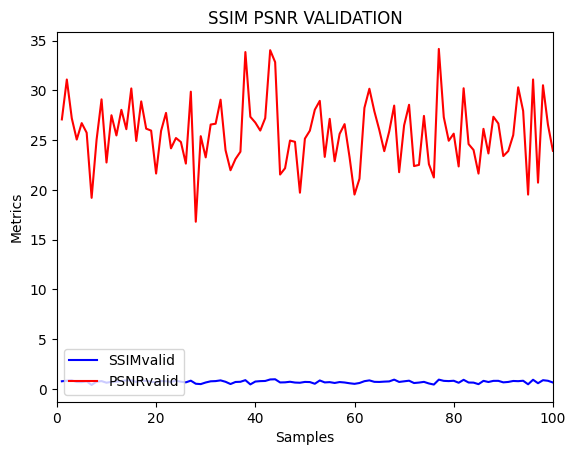

In [ ]:
d_losses_train, g_losses_avg_train, g_losses_binary_train, g_losses_mse_train, psnr_train, ssim_train,epoch_train = load_checkpoint(selectedType = 'train' )
d_losses_test, g_losses_avg_test, g_losses_binary_test, g_losses_mse_test, psnr_test, ssim_test,epoch_test = load_checkpoint(selectedType = 'test' )
psnr_valid, ssim_valid = load_checkpoint(selectedType = 'valid' )

#epochs = range(1, epoch_train + 1)
epochs = range(1, 100 + 1)
path = '/content/drive/MyDrive/DeepProject/results/plots'
'''
plt.plot(epochs, g_losses_avg_train, '-r', label='GLossTrain')
plt.plot(epochs, g_losses_avg_test, '-b', label='GLossTest')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('Train_Loss')
plt.legend(loc="upper left")
plt.ylim([0,2500])

plt.xlim([0,190])

plt.savefig(os.path.join(path,'gloss_test_train_fullScale_190'))
plt.show()

plt.plot(epochs, g_losses_avg_train, '-r', label='GLossTrain')
plt.plot(epochs, g_losses_avg_test, '-b', label='GLossTest')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('Train_Loss')
plt.ylim([0,50])
plt.xlim([0,190])
plt.legend(loc="upper left")
plt.savefig(os.path.join(path,'gloss_test_train_700_190'))
plt.show()


plt.plot(epochs, d_losses_train, '-r', label='DLossTrain')
plt.plot(epochs, d_losses_test, '-b', label='DLossTest')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('Test Loss')
plt.xlim([0,190])
plt.ylim([0,15])
plt.legend(loc="upper left")
plt.savefig(os.path.join(path,'dloss_test_train_15_190'))
plt.show()

plt.plot(epochs, psnr_test, '-b', label='PSNRvalid_test')
plt.plot(epochs, psnr_train, '-r', label='PSNRvalid_train')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('PSNR')
plt.xlim([0,190])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'psnr_190'))
plt.show()

plt.plot(epochs, ssim_test, '-b', label='SSIMtest')
plt.plot(epochs, ssim_train, '-r', label='SSIMtrain')
plt.xlabel('Epochs')
plt.ylabel('Losses Values')
plt.title('SSIM')
plt.xlim([0,190])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'ssim_190'))

plt.show()
'''

plt.plot(epochs, ssim_valid, '-b', label='SSIMvalid')
plt.plot(epochs, psnr_valid, '-r', label='PSNRvalid')
plt.xlabel('Samples')
plt.ylabel('Metrics')
plt.title('SSIM PSNR VALIDATION')
plt.xlim([0,100])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'PSNRSSIMVALID'))

plt.show()


In [ ]:
def outputSingleImage():

  generator.load_weights('/content/drive/MyDrive/DeepProject/models/genblock_499.hdf5')
  print('loaded generator, ')
  filename = 'image.png'
  outfilename = f'generated_{filename}'
  outfilename_or = f'or_{filename}'
  resultpath = '/content'
  img1 = cv2.cvtColor(cv2.imread(os.path.join('/content', filename)) , cv2.COLOR_BGR2RGB)


  img1_low_resolution = np.expand_dims(img1, axis=0)
  generator.trainable = False
  gen_imgs = generator.predict_on_batch(img1_low_resolution)

  cv2.imwrite(os.path.join(resultpath,outfilename_or), cv2.cvtColor(img1_low_resolution[0] , cv2.COLOR_RGB2BGR))
  cv2.imwrite(os.path.join(resultpath,outfilename), cv2.cvtColor(gen_imgs[0] , cv2.COLOR_RGB2BGR))
  generator.trainable = True

outputSingleImage()

loaded generator, 


In [ ]:
#train(epochs=50, batch_size=8,selectedType='train')